<a href="https://colab.research.google.com/github/mmaitino/ENB_data/blob/main/Classifier_ENB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

O objetivo deste script é testar algumas formas de construir um classificador de interações cooperativas/não-cooperativas entre países a partir de relatórios de negociações do [ENB](https://enb.iisd.org/).

Para isso, parto de uma versão (editada) do banco de dados [_Relational Data between Parties to the UN Framework Convention on Climate Change_, de Paula Castro](https://doi.org/10.7910/DVN/IVLEHB), usando, como input, os trechos dos textos que os anotadores indicaram como relevantes.

Temos, então, textos como "_Brazil, with China, called for further commitment of Annex-1 countries_" ou "_The US criticized the EU for their position on forests_". Antes da classificação, esses trechos foram tratados, "censurando" os países mencionados (aqueles que concordam/discordam são subtituídos por SENDER, os alvos da fala por TARGET e os demais por OTHER).

O objetivo é termos um modelo capaz de classificar esse tipo de texto entre duas classes: cooperação ou não-cooperação.

A ideia é passar por diferentes soluções, identificando a mais adequada e efetiva para nosso caso. No momento, o script conta com:

- Zero-shot classification
- Um classificador montado a partir dos hidden states do modelo base
- Finetuning do modelo base com os dados rotulados


Uma referência de possíveis soluções para nosso problema aparece no fluxograma abaixo, retirado de Tunstall et al., NLP with transformers, p. 250:

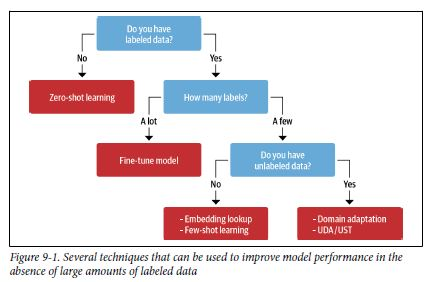

# Preliminares

## Importando os dados

In [ ]:
import pandas as pd

In [ ]:
path = '/content/twocountry_v1.csv'
db = pd.read_csv(path, sep = ";")

In [ ]:
db.head()

,Unnamed: 0,obs_id,quote_id,e_date,ENB_Nr,Country1,Country2,quote,masked_quote,cooperation,relation
0,1,5,3157,1995-02-07,2,Kuwait,Saudi Arabia,"Saudi Arabia, supported by Kuwait, suggested t...","TARGET, SUPPORTED BY SENDER, SUGGESTED THAT IN...",1,2
1,2,89,775,2008-04-01,358,Canada,Argentina,CANADA highlighted links between the AWG and A...,SENDER HIGHLIGHTED LINKS BETWEEN THE AWG AND A...,1,3
2,3,90,775,2008-04-01,358,Argentina,Canada,CANADA highlighted links between the AWG and A...,TARGET HIGHLIGHTED LINKS BETWEEN THE AWG AND A...,1,3
3,4,97,597,2008-04-01,358,New Zealand,Brazil,BRAZIL noted that the AWG’s success depends on...,TARGET NOTED THAT THE AWG’S SUCCESS DEPENDS ON...,0,6
4,5,145,1086,2008-04-01,358,China,Chile,"CHINA, with CHILE, emphasized that action from...","SENDER, WITH TARGET, EMPHASIZED THAT ACTION FR...",1,3


In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
db['label'] = np.where(db['cooperation'] == 1, 'cooperation', 'conflict')
le = LabelEncoder()
db['label'] = le.fit_transform(db['label'])

In [ ]:
db.head()

,Unnamed: 0,obs_id,quote_id,e_date,ENB_Nr,Country1,Country2,quote,masked_quote,cooperation,relation,label
0,1,5,3157,1995-02-07,2,Kuwait,Saudi Arabia,"Saudi Arabia, supported by Kuwait, suggested t...","TARGET, SUPPORTED BY SENDER, SUGGESTED THAT IN...",1,2,1
1,2,89,775,2008-04-01,358,Canada,Argentina,CANADA highlighted links between the AWG and A...,SENDER HIGHLIGHTED LINKS BETWEEN THE AWG AND A...,1,3,1
2,3,90,775,2008-04-01,358,Argentina,Canada,CANADA highlighted links between the AWG and A...,TARGET HIGHLIGHTED LINKS BETWEEN THE AWG AND A...,1,3,1
3,4,97,597,2008-04-01,358,New Zealand,Brazil,BRAZIL noted that the AWG’s success depends on...,TARGET NOTED THAT THE AWG’S SUCCESS DEPENDS ON...,0,6,0
4,5,145,1086,2008-04-01,358,China,Chile,"CHINA, with CHILE, emphasized that action from...","SENDER, WITH TARGET, EMPHASIZED THAT ACTION FR...",1,3,1


In [ ]:
db['text'] = db['masked_quote']

## Separando treino e teste

Pra maior facilidade ao lidar com transformers, usamos os dados no formato de data dictionary usado pelo pacote datasets.

In [ ]:
# !pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is

In [ ]:
from datasets import Dataset,DatasetDict

No momento, o código trabalha só com set de validação. Mais adiante, a ideia é otimizar hiperparâmetros e depois usar o banco de teste real.

- Pensando nos meus dados, talvez fosse interessante testar desempenho com divisão temporal, não aleatória. Os dados não rotulados, que pretendo classificar, correspondem a um período posterior aos dados do banco de Castro.

In [ ]:
# Estou fazendo as divisões já no formato dataset, mas poderia inverter a ordem,
# dividindo primeiro (com sklearn, e.g.) e depois converter pro formato

ds = Dataset.from_pandas(db[['text','label']])
# divide primeiro em teste e treino (incluindo valid)
train_test = ds.train_test_split(test_size = 0.2, seed=42)
test_set = train_test['test']
# print("Teste:", test_set, "\n")
# divide agora o treino em treino efetivo e validação
train_valid = train_test['train'].train_test_split(test_size = 0.25, seed=42)
# print("Divisão Treino - Validação: \n", dataset)

# junto todos em um mesmo dicionario
dataset = DatasetDict()
dataset['train'] = train_valid['train']
dataset['test'] = test_set
dataset['validation'] = train_valid['test']
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1041
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 348
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 347
    })
})

In [ ]:
train = dataset['train']
train[0]

{'text': 'TARGET, OPPOSED BY SENDER, SUPPORTED A ROLE FOR THE COP/MOP.',
 'label': 0}

# Zero Shot Classification

Como são treinados com um grande volume de textos, os modelos de linguagem nos oferecem a possibilidade de classificar nossos textos sem maiores informações prévias. Isso é chamado de 'zero-shot classification' (zero porque não são fornecidos exemplos prévios de classificação)

Como temos um banco com textos já classificados (entre cooperação e não-cooperação), é improvável que zero-shot seja a melhor solução para o problema. Ainda assim, pode servir como um baseline interessante para nossos classificadores.

In [ ]:
example_coop = train[13]['text']
example_conf = train[0]['text']

In [ ]:
print("Cooperação:\n", example_coop, "\n Conflito:\n", example_conf)

Cooperação:
 THE REPUBLIC OF SENDER AND TARGET PROPOSED ADDRESSING THE ISSUE (REDD) IN THE UNFCCC DIALOGUE ON LONG-TERM COOPERATIVE ACTION 
 Conflito:
 TARGET, OPPOSED BY SENDER, SUPPORTED A ROLE FOR THE COP/MOP.


Vamos usar um modelo básico, uma versão do BERT que não reconhece variações entre maiúsculas e minúsculas. A biblioteca _transformers_ permite importar facilmente qualquer modelo do [HuggingFace](https://huggingface.co/). Em geral, o ideal é usar um modelo já treinado para a tarefa que você deseja realizar (classificação, análise de sentimentos, mask filling, NLI, etc) e treinado em dados de textos mais semelhantes ao seu (língua, tipo de texto, contexto, etc).

Além de testar diferentes modelos, podemos usar diferentes estratégias para zero-shot classification usando modelos pré-treinados.

In [ ]:
from transformers import pipeline
modelo = "bert-base-uncased"

### Mask-Filling

Como uma primeira tentativa, vamos usar um modelo de "mask filling", que busca prever a palavra "censurada" em um texto mais amplo.
Podemos usar esse tipo de modelo para classificar arquivos ao criar um texto como _"Texto a ser classificado. A frase anterior é sobre [MASK]"_

In [ ]:
pipe = pipeline("fill-mask", model=modelo)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
prompt_assunto = "The previous text is about [MASK]."
output = pipe(example_coop + prompt_assunto)
for element in output:
  print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token cooperation:	0.103%
Token implementation:	0.077%
Token negotiation:	0.035%
Token it:	0.035%
Token development:	0.023%


In [ ]:
prompt_ENB = "The sentence is about [MASK] between Sender and Target."
output = pipe(example_coop + prompt_ENB)
for element in output:
  print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token dialogue:	0.257%
Token cooperation:	0.168%
Token communication:	0.154%
Token interaction:	0.051%
Token agreement:	0.050%


Como se vê, os resultados não necessariamente falam sobre o que nos interessa (cooperação/não-cooperação). Isso não é um problema: podemos usar o mesmo modelo, mas ver a probabilidade que o modelo retorna para palavras específicas. Note-se, porém, que o resultado pode variar muito a depender do label específico escolhido, mesmo que sejam palavras de sentido similar. Uma estratégia possível para reduzir esse viés seria encontrar uma forma de agregar resultados (e.g., média)

In [ ]:
output = pipe(example_coop + prompt_ENB, targets=["cooperation", "conflict", "agreement","disagreement"])
for element in output:
  print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token cooperation:	0.168%
Token agreement:	0.050%
Token conflict:	0.029%
Token disagreement:	0.002%


In [ ]:
output = pipe(example_conf + prompt_ENB, targets=["cooperation", "conflict", "agreement","disagreement"])
for element in output:
  print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token conflict:	0.048%
Token agreement:	0.038%
Token cooperation:	0.020%
Token disagreement:	0.004%


### Natural Language Inference

Uma segunda forma de fazermos zero-shot classification é usar modelos para a tarefa de Natural Language Inference (NLI). NLI é uma tarefa de análise lógica: você fornece ao modelo uma premissa e uma hipótese, e o modelo retorna a relação entre elas: Entailment (Implicação), Contradiction (Contradição) ou Neutral (Neutro).


O efeito esperado é algo como:

**Premissa**: *Está acontecendo um jogo de futebol no Pacaembu.*

1. **Hipótese**: *Há jogadores no Pacaembu.* **Conclusão 1**: Implicação

2. **Hipótese**: Taylor Swift está dando um show no Pacaembu.* **Conclusão**: Contradição

3. **Hipótese**: *Um menino compra pipoca.* **Conclusão**: Neutro

Podemos buscar um modelo de NLI que pareça interessante por meio de uma busca na plataforma [Hugging Face](https://huggingface.co/models). Em seguida, basta copiar o nome do modelo e do usuário que fez o upload ("modelo/usuario") e incluir na função pipeline.

Mesmo se não estamos explicitarmos um modelo, só a tarefa, a função pipeline vai funcionar, carregando um modelo padrão pré-definido para a tarefa.

In [ ]:
from transformers import pipeline

modelo_NLI = "tasksource/deberta-small-long-nli"
pipe = pipeline("zero-shot-classification", model = modelo_NLI)


Device set to use cpu


O formato padrão das hipóteses de zero-shot classification é "This text is about {label}", retornando o valor de implication. Se quisermos, podemos personalizar as hipóteses de acordo com nosso interesse. Evidentemente, algumas mudanças podem prejudicar a eficiência do modelo, que foi treinado com outro formato de hipótese.

In [ ]:
# Usando a hipótese padrão
candidate_labels = ["cooperation", "conflict", "agreement","disagreement"]
# Com a opção multi_label retornamos todos os scores, não só classe + provavel
output_tst = pipe([example_coop, example_conf], candidate_labels, multi_label=True)

TypeError: TextClassificationPipeline.__call__() takes 2 positional arguments but 3 were given

In [ ]:
print("Coop: \n", pd.DataFrame(output_tst[0]), "\n")
print("Conf: \n", pd.DataFrame(output_tst[1]))

Coop: 
                                             sequence        labels    scores
0  THE REPUBLIC OF SENDER AND TARGET PROPOSED ADD...   cooperation  0.871149
1  THE REPUBLIC OF SENDER AND TARGET PROPOSED ADD...     agreement  0.562369
2  THE REPUBLIC OF SENDER AND TARGET PROPOSED ADD...  disagreement  0.471193
3  THE REPUBLIC OF SENDER AND TARGET PROPOSED ADD...      conflict  0.338724 

Conf: 
                                             sequence        labels    scores
0  TARGET, OPPOSED BY SENDER, SUPPORTED A ROLE FO...  disagreement  0.695995
1  TARGET, OPPOSED BY SENDER, SUPPORTED A ROLE FO...      conflict  0.650786
2  TARGET, OPPOSED BY SENDER, SUPPORTED A ROLE FO...     agreement  0.571243
3  TARGET, OPPOSED BY SENDER, SUPPORTED A ROLE FO...   cooperation  0.564165


Agora vamos testar um novo formato de hipótese: _Sender [label] with target_

In [ ]:
new_labels = ["cooperates", "agrees", "is in conflict", "disagrees"]

dic_ls = []

for example in [example_coop, example_conf]:
  for label in new_labels:
    new_hypothesis = "Sender " + label + " with Target"
    nli_dic = dict(text = example, text_pair = new_hypothesis)
    dic_ls.append(nli_dic)

dic_ls

[{'text': 'THE REPUBLIC OF SENDER AND TARGET PROPOSED ADDRESSING THE ISSUE (REDD) IN THE UNFCCC DIALOGUE ON LONG-TERM COOPERATIVE ACTION',
  'text_pair': 'Sender cooperates with Target'},
 {'text': 'THE REPUBLIC OF SENDER AND TARGET PROPOSED ADDRESSING THE ISSUE (REDD) IN THE UNFCCC DIALOGUE ON LONG-TERM COOPERATIVE ACTION',
  'text_pair': 'Sender agrees with Target'},
 {'text': 'THE REPUBLIC OF SENDER AND TARGET PROPOSED ADDRESSING THE ISSUE (REDD) IN THE UNFCCC DIALOGUE ON LONG-TERM COOPERATIVE ACTION',
  'text_pair': 'Sender is in conflict with Target'},
 {'text': 'THE REPUBLIC OF SENDER AND TARGET PROPOSED ADDRESSING THE ISSUE (REDD) IN THE UNFCCC DIALOGUE ON LONG-TERM COOPERATIVE ACTION',
  'text_pair': 'Sender disagrees with Target'},
 {'text': 'TARGET, OPPOSED BY SENDER, SUPPORTED A ROLE FOR THE COP/MOP.',
  'text_pair': 'Sender cooperates with Target'},
 {'text': 'TARGET, OPPOSED BY SENDER, SUPPORTED A ROLE FOR THE COP/MOP.',
  'text_pair': 'Sender agrees with Target'},
 {'text

In [ ]:
pipe = pipeline("text-classification",model = modelo_NLI)

output_newh = pipe(dic_ls)

Device set to use cpu


In [ ]:
zeroshot = pd.DataFrame(dic_ls)
zeroshot['label'] = pd.DataFrame(output_newh)['label']
zeroshot['score'] = pd.DataFrame(output_newh)['score']
zeroshot

,text,text_pair,label,score
0,THE REPUBLIC OF SENDER AND TARGET PROPOSED ADD...,Sender cooperates with Target,entailment,0.821941
1,THE REPUBLIC OF SENDER AND TARGET PROPOSED ADD...,Sender agrees with Target,neutral,0.429309
2,THE REPUBLIC OF SENDER AND TARGET PROPOSED ADD...,Sender is in conflict with Target,neutral,0.794806
3,THE REPUBLIC OF SENDER AND TARGET PROPOSED ADD...,Sender disagrees with Target,contradiction,0.476530
4,"TARGET, OPPOSED BY SENDER, SUPPORTED A ROLE FO...",Sender cooperates with Target,contradiction,0.747964
5,"TARGET, OPPOSED BY SENDER, SUPPORTED A ROLE FO...",Sender agrees with Target,contradiction,0.774014
6,"TARGET, OPPOSED BY SENDER, SUPPORTED A ROLE FO...",Sender is in conflict with Target,entailment,0.927115
7,"TARGET, OPPOSED BY SENDER, SUPPORTED A ROLE FO...",Sender disagrees with Target,entailment,0.975239


#### Avaliação do modelo
Como não temos um problema que exija, de fato, zero-shot classification (i.e., como temos os dados já classificados), podemos avaliar facilmente o desempenho do modelo. Para isso, vamos aplicar nosso "classificador" baseado em NLI a todo o banco e, em seguida, avaliar o desempenho comparando as classes previstas e as classes reais.

In [ ]:
pipe = pipeline("zero-shot-classification", model = modelo_NLI)

# Pra facilitar a implementação, vamos usar o formato padrão de zero-shot classification
# e só dois labels como candidatos
# Com a opção multi-label, poderíamos trabalhar com vários labels simultâneos. O modelo estima probabilidade pra cada um.
# Sem ela, o modelo calcula a probabilidade entre os labels disponíveis (soma = 1).
# Vamos trabalhar com classificação binária, de modo que teremos que selecionar com nossos próprios critérios a classe relevantes.

labels_simples = ['cooperation', "disagreement"]

def zero_shot_pipeline(example):
  output = pipe(example["text"], labels_simples)
  example["predicted_labels"] = output["labels"]
  example["scores"] = output["scores"]
  return example

# pra rodar mais rápido, vamos usar só o banco de validação
ds_zero_shot = dataset["validation"].map(zero_shot_pipeline)

Device set to use cpu


Map:   0%|          | 0/347 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
zshot_pd = ds_zero_shot.to_pandas()

In [ ]:
zshot_pd

,text,label,predicted_labels,scores
0,SENDER STATED THAT THERE WAS NO NEED TO WAIT F...,1,"[cooperation, disagreement]","[0.5169456005096436, 0.48305442929267883]"
1,THE TARGET SAID THE FLEXIBILITY OF A FULL RANG...,0,"[cooperation, disagreement]","[0.6311368346214294, 0.36886319518089294]"
2,"TARGET, OPPOSED BY SENDER, REQUESTED\r\nREFERE...",0,"[disagreement, cooperation]","[0.5374364852905273, 0.46256351470947266]"
3,SENDER AND\r\nTARGET CALLED FOR LANGUAGE THAT ...,1,"[cooperation, disagreement]","[0.6808712482452393, 0.31912878155708313]"
4,"TARGET, OPPOSED BY SENDER, STRESSED THE\r\nNEE...",0,"[disagreement, cooperation]","[0.5859814286231995, 0.4140186309814453]"
...,...,...,...,...
342,"SENDER, WITH THE TARGET, NOTED COP DECISIONS U...",1,"[cooperation, disagreement]","[0.6366432905197144, 0.3633567690849304]"
343,"THE TARGET, WITH SENDER, SAID THERE SHOULD BE ...",1,"[cooperation, disagreement]","[0.5412002801895142, 0.45879971981048584]"
344,SENDER AND TARGET WELCOMED WORK ON A\r\nTECHNI...,1,"[cooperation, disagreement]","[0.7739158272743225, 0.22608418762683868]"
345,TARGET AND SENDER DREW ATTENTION TO CDM POTENT...,1,"[cooperation, disagreement]","[0.7145063281059265, 0.2854936420917511]"


In [ ]:
def return_toplabel(labels, score_arrays):
  index = score_arrays.tolist().index(max(score_arrays))
  return labels[index]

In [ ]:
zshot_pd['top_label'] = zshot_pd.apply(
    lambda row: return_toplabel(row['predicted_labels'], row['scores']), axis=1
    )

Nosso label real não corresponde exatamente aos predicted labels, de modo que ainda não podemos compará-los. Vamos, primeiro, transformar as previsões de Agreement e Cooperation em 1 (cooperativo) e de Disagreement e Conflict em 0 (não-cooperativo).

In [ ]:
zshot_pd['predicted_label'] = zshot_pd['top_label'].isin(['cooperation', 'agreement']).astype(int)

In [ ]:
zshot_pd

,text,label,predicted_labels,scores,top_label,predicted_label
0,SENDER STATED THAT THERE WAS NO NEED TO WAIT F...,1,"[cooperation, disagreement]","[0.5169456005096436, 0.48305442929267883]",cooperation,1
1,THE TARGET SAID THE FLEXIBILITY OF A FULL RANG...,0,"[cooperation, disagreement]","[0.6311368346214294, 0.36886319518089294]",cooperation,1
2,"TARGET, OPPOSED BY SENDER, REQUESTED\r\nREFERE...",0,"[disagreement, cooperation]","[0.5374364852905273, 0.46256351470947266]",disagreement,0
3,SENDER AND\r\nTARGET CALLED FOR LANGUAGE THAT ...,1,"[cooperation, disagreement]","[0.6808712482452393, 0.31912878155708313]",cooperation,1
4,"TARGET, OPPOSED BY SENDER, STRESSED THE\r\nNEE...",0,"[disagreement, cooperation]","[0.5859814286231995, 0.4140186309814453]",disagreement,0
...,...,...,...,...,...,...
342,"SENDER, WITH THE TARGET, NOTED COP DECISIONS U...",1,"[cooperation, disagreement]","[0.6366432905197144, 0.3633567690849304]",cooperation,1
343,"THE TARGET, WITH SENDER, SAID THERE SHOULD BE ...",1,"[cooperation, disagreement]","[0.5412002801895142, 0.45879971981048584]",cooperation,1
344,SENDER AND TARGET WELCOMED WORK ON A\r\nTECHNI...,1,"[cooperation, disagreement]","[0.7739158272743225, 0.22608418762683868]",cooperation,1
345,TARGET AND SENDER DREW ATTENTION TO CDM POTENT...,1,"[cooperation, disagreement]","[0.7145063281059265, 0.2854936420917511]",cooperation,1


In [ ]:
from sklearn.metrics import classification_report
y_true = np.array(zshot_pd["label"])
y_pred = np.array(zshot_pd["predicted_label"])
print(classification_report(y_true, y_pred, target_names = ["Disagreement", "Cooperation"]))

              precision    recall  f1-score   support

Disagreement       0.20      0.61      0.30        31
 Cooperation       0.95      0.76      0.85       316

    accuracy                           0.75       347
   macro avg       0.58      0.69      0.57       347
weighted avg       0.89      0.75      0.80       347



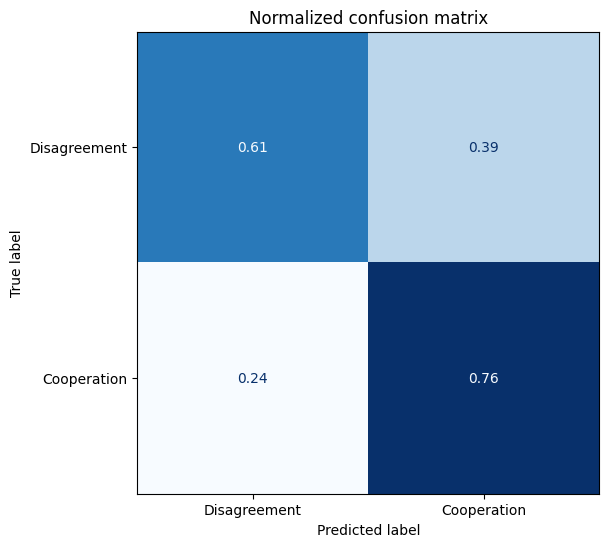

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds)
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Confusion matrix")
  plt.show()

plot_confusion_matrix(y_pred, y_true, labels = ["Disagreement", "Cooperation"])

# Usando modelos pré-treinados pra extrair features e treinar um classificador

## Tokenizando o banco

In [ ]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True) #padding garante que inputs vao ter mesmo tamanho

In [ ]:
print(tokenize(dataset["train"][:2]))

{'input_ids': [[101, 4539, 1010, 4941, 2011, 4604, 2121, 1010, 3569, 1037, 2535, 2005, 1996, 8872, 1013, 9587, 2361, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2002, 1006, 4604, 2121, 1007, 3264, 9525, 8107, 2005, 2248, 6792, 1010, 2107, 2004, 2216, 2008, 2024, 4753, 2389, 2030, 8015, 1011, 2241, 1012, 1006, 1012, 1012, 1012, 1007, 4539, 9720, 6594, 2006, 1037, 4753, 2389, 3921, 1998, 2006, 12135, 1012, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [ ]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)
print(dataset_encoded["train"].column_names)

NameError: name 'dataset' is not defined

## Treinando modelo

### Extraindo hidden states

In [ ]:
import torch

In [ ]:
from transformers import AutoModel
model_ckpt = "distilbert-base-uncased"
device = "cpu"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #com pytorch, seleciona gpu se tiver, senao cpu
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [ ]:
# extrair hidden states
def extract_hidden_states(batch):
  # Place model inputs on the GPU
  inputs = {k:v.to(device) for k,v in batch.items()
  if k in tokenizer.model_input_names}
  # Extract last hidden states
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  # Return vector for [CLS] token
  return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [ ]:
# converter input_ids e attention_masks do transformers pro formato de tensores do pytorch
dataset_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [ ]:
dataset_hidden = dataset_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/1041 [00:00<?, ? examples/s]

Map:   0%|          | 0/348 [00:00<?, ? examples/s]

Map:   0%|          | 0/347 [00:00<?, ? examples/s]

In [ ]:
dataset_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

### Treinando um classificador

Com os hidden states, podemos treinar agora um classificador, usando-os como features. Os labels (no caso, cooperação 1 ou 0) serão o target.

In [ ]:
import numpy as np
X_train = np.array(dataset_hidden["train"]["hidden_state"])
X_valid = np.array(dataset_hidden["validation"]["hidden_state"])
y_train = np.array(dataset_hidden["train"]["label"])
y_valid = np.array(dataset_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((1041, 768), (347, 768))

Vamos treinar um modelo simples de regressão logística com esses dados

In [ ]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter=3000) # We increase `max_iter` to guarantee convergence
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid) #accuracy

NameError: name 'X_train' is not defined

Como baseline para comparação, vejamos o desempenho de um "dummy classifier" que só coloca o label mais frequente

In [ ]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.9106628242074928

Resultado não foi tão superior quanto se poderia imaginar.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_valid, y_preds))

NameError: name 'y_valid' is not defined

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
labels = ["non-coop", 'coop'] #garantir que ordem está certa!

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds)
  fig, ax = plt.subplots(figsize=(6, 6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Confusion matrix")
  plt.show()

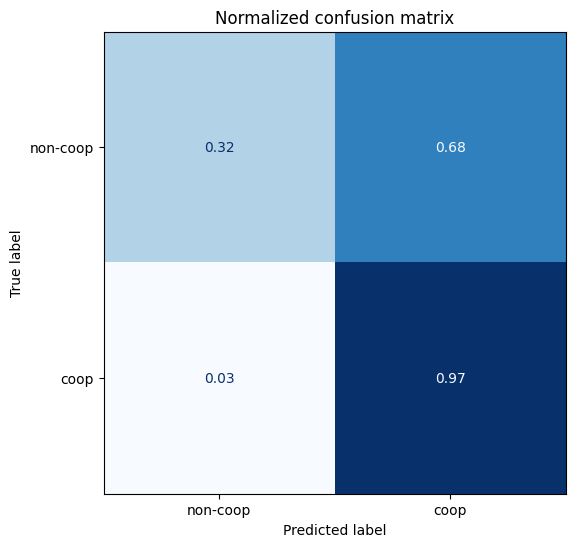

In [ ]:
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid)

Os erros são quase todos na categoria minoritária (conflito). É preciso pensar melhor no desbalanceamento das classes.

### Corrigindo desbalanceamento

In [ ]:
from imblearn.over_sampling import SMOTE, SMOTENC

sm = SMOTENC(categorical_features=[0,1],
             random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [ ]:
print("Original:", np.unique(y_train, return_counts = True), "\n")
print("SMOTE Rebalanced:", np.unique(y_train_sm, return_counts = True))

Original: (array([0, 1]), array([112, 929])) 

SMOTE Rebalanced: (array([0, 1]), array([929, 929]))


In [ ]:
#updating Dummy Classifier with SMOTE’d data
clf_dummy_sm = DummyClassifier(random_state=42)
clf_dummy_sm.fit(X_train_sm, y_train_sm)

DummyClassifier(random_state=42)

In [ ]:
clf_dummy_sm.score(X_valid, y_valid)

0.0893371757925072

In [ ]:
#fit da regressao logística com dados SMOTE
y_pred = clf_dummy_sm.predict(X_valid)
lr_clf = LogisticRegression(max_iter=3000) # We increase `max_iter` to guarantee convergence
lr_clf.fit(X_train_sm, y_train_sm)
y_pred = lr_clf.predict(X_valid)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_valid, y_pred)

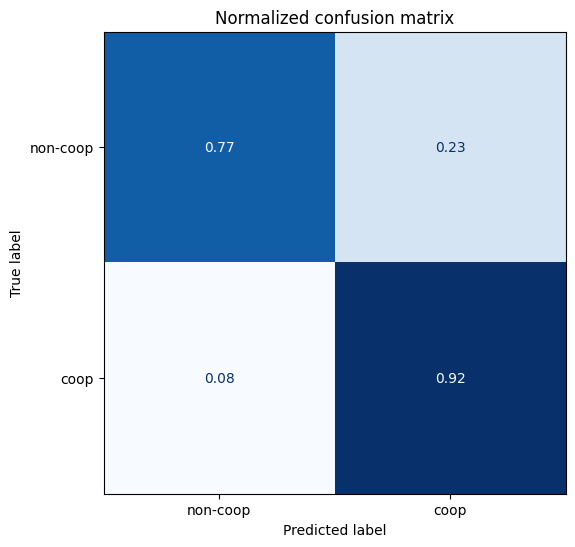

In [ ]:
plot_confusion_matrix(y_pred, y_valid)

Ainda temos muitos casos de não-cooperação classificados como cooperação, mas, com o rebalanceamento, o desempenho melhorou muito.

# Treinando um classificador com fine-tuning

No método anterior, usamos os hidden states do modelo pré treinado como features fixos para um modelo de classificação. Agora, vamos treinar uma nova camada do modelo pré-treinado. Com isso, resolvemos o problema de o modelo ter, originalmente, um foco distinto do nosso e ser treinado com dados diferentes, ajustando-o para nossos objetivos.

Para isso, usamos a API do Transformers.

Como temos poucos dados, o finetuning foi relativamente rápido (coisa de 30min na cpu)

### (opcional) login no HuggingFace pra salvar o modelo

Se salvamos os pesos do modelo, podemos utilizá-lo facilmente depois para outras tarefas. Basta seguir os passos padrão para puxar um modelo do huggingface via transformers

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

### Finetuning

In [ ]:
from transformers import AutoModelForSequenceClassification
num_labels = 6
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))
# estou usando como base o mesmo modelo definido anteriormente

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [ ]:
batch_size = 64
logging_steps = len(dataset_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-ENB"

In [ ]:
from transformers import Trainer, TrainingArguments
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  eval_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False, #ativar se quiser enviar modelo pro HF
                                  report_to="none", #desativar se quiser fazer log
                                  log_level="error")

In [ ]:
trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=dataset_encoded["train"],
                  eval_dataset=dataset_encoded["validation"],
                  processing_class=tokenizer)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.240700,0.620881,0.914747,0.874018
2,0.558400,0.443219,0.914747,0.874018


TrainOutput(global_step=42, training_loss=0.8784713205837068, metrics={'train_runtime': 1030.552, 'train_samples_per_second': 2.527, 'train_steps_per_second': 0.041, 'total_flos': 41099907156336.0, 'train_loss': 0.8784713205837068, 'epoch': 2.0})

In [ ]:
preds_output = trainer.predict(dataset_encoded["validation"])

In [ ]:
preds_output.metrics

{'test_loss': 0.4432193636894226,
 'test_accuracy': 0.9147465437788018,
 'test_f1': 0.8740177566310092,
 'test_runtime': 40.9242,
 'test_samples_per_second': 10.605,
 'test_steps_per_second': 0.171}

In [ ]:
import numpy as np
y_preds = np.argmax(preds_output.predictions, axis=1)
# plot_confusion_matrix(y_preds, y_test)

### Investigando os erros do modelo

In [ ]:
from torch.nn.functional import cross_entropy
# Função que retorna o valor da loss function junto com o label

def forward_pass_with_label(batch):
  # Place all input tensors on the same device as the model
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}

  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=-1)
    loss = cross_entropy(output.logits, batch["label"].to(device),
                         reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
  return {"loss": loss.cpu().numpy(), "predicted_label": pred_label.cpu().numpy()}

In [ ]:
# Convert our dataset back to PyTorch tensors
dataset_encoded.set_format("torch",
columns=["input_ids", "attention_mask", "label"])
# Compute loss values
dataset_encoded["validation"] = dataset_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/434 [00:00<?, ? examples/s]

In [ ]:
dataset_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = dataset_encoded["validation"][:][cols]
# df_test["label"] = df_test["label"].apply(label_int2str)
# df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

In [ ]:
erros = df_test.sort_values("loss", ascending=False)
# erros.to_csv("erros.csv")
erros.head(10)

,text,label,predicted_label,loss
321,TARGET AND THE SENDER DISAGREED AS TO THE SUB-...,0,1,2.687320
182,TARGET EMPHASIZED THAT COUNTRIES WITH\r\nTRANS...,0,1,2.659749
219,TARGET NOTED ACCEPTANCE OF THE REVIEW FINDINGS...,0,1,2.649387
26,SENDER EXPRESSED DISAPPOINTMENT WITH\r\nTHE WO...,0,1,2.636678
19,THE TARGET SAID THE FINDINGS EMPHASIZE THE NEE...,0,1,2.636171
386,TARGET HIGHLIGHTED THE NEED TO FOCUS ON FURTHE...,0,1,2.621834
380,HE (TARGET) DID NOT THINK PARTIES SHOULD BE NA...,0,1,2.619584
302,"TARGET, OPPOSED BY SENDER, SAID THE DATA REPOR...",0,1,2.619028
140,SENDER OPPOSED\r\nTARGET’S PROPOSAL TO CLASSIF...,0,1,2.615305
317,THE CHAIR ATTEMPTED TO GIVE THE FLOOR TO AN EN...,0,1,2.610699
